In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
from pylab import *

In [2]:
data = np.load("labels_ann_5k.npy")
data.shape

(5000, 7)

In [3]:
FROGS = np.load("FROG_5k.npy")
FROGS.shape

(5000, 128, 128)

In [4]:
FROGS = FROGS.reshape(5000,-1)

In [5]:
a_max = np.max(FROGS)
b_min = np.min(FROGS)
X_orig = (FROGS - b_min)/(a_max - b_min)
X_train = X_orig[:4600, :]
X_val = X_orig[4600:, :]

In [6]:
Y = np.zeros([5000,7])
Y[:,0] = (data[:,0] - 295)/(695-295)
Y[:,1] = (data[:,1] - 300)/(1000-300)
Y[:,2] = (data[:,2] - 0.6)/(1.5-0.6)
Y[:,3] = (data[:,3] - 0.6)/(1.5-0.6)
Y[:,4] = (data[:,4] + 0.005)/(0.005 + 0.005)
Y[:,5] = (data[:,5] + 0.0005)/(0.0005 + 0.0005)
Y[:,6] = (data[:,6] + 1000)/(5000+1000)

In [7]:
Y_train = Y[:4600]
Y_val = Y[4600:]

In [8]:
model = keras.models.load_model("ann-v2-0.003lr-1000epochs")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [9]:
model.evaluate(X_val, Y_val)

400/400 [==============================] - 0s 644us/sample - loss: 0.0295 - acc: 0.5900 - mean_absolute_error: 0.1112


[0.02950566276907921, 0.59, 0.11124821]

In [10]:
def predict_params(trace):
    params = model.predict(trace).reshape(7)
    t1 = params[0]*(695-295) + 295
    t2 = params[1]*(1000-300) + 300
    A1 = params[2]*(1.5-0.6) + 0.6
    A2 = params[3]*(1.5-0.6) + 0.6
    f0 = params[4]*(0.005+0.005) - 0.005
    f1 = params[5]*(0.0005+0.0005) - 0.0005
    tau1 = params[6]*(5000+1000) - 1000
    pred = [t1, t2, A1, A2, f0, f1, tau1]
    print("T1 =", t1, "\n", "T2 =", t2, "\n", "A1 =", A1, "\n", "A2 =", A2, "\n", "F0 =", f0, "\n", "F1 =", f1, "\n", "Tau1 =", tau1, "\n")
    return pred

In [11]:
predict_params(X_val[41].reshape(1,16384))

T1 = 430.717511177063 
 T2 = 662.0863497257233 
 A1 = 0.7342730462551117 
 A2 = 0.6433055520057678 
 F0 = -0.0019570860266685487 
 F1 = -0.0001482958495616913 
 Tau1 = 1366.718828678131 



[430.717511177063,
 662.0863497257233,
 0.7342730462551117,
 0.6433055520057678,
 -0.0019570860266685487,
 -0.0001482958495616913,
 1366.718828678131]

In [266]:
e0 = np.loadtxt('837nm.dat')		#load the reference pulse, pump @836 nm
e0 = e0.T
e1 = np.sqrt(e0[1])
e1_ph = e0[2]
e = np.array(e1)*np.exp(-1j*(np.array(e1_ph)))		#reforming E-field

original_trace = np.loadtxt('trace/trace10.frg')		#load FROG trace from experiment

N = len(e0[0])		#timesteps
N_max = np.max(e0[0])
N_min = np.min(e0[0])

t = e0[0]-N_min
T0 = N_max-N_min	#total time duration
dt = T0/(N-1)
df = 1.0/T0		#frequency steps
TD = N			#time delay for FROG-trace generation
freq = np.arange(0,1/dt+df,df)*1000

In [267]:
## for generation of Gaussian pulses
def gaussian_pulse(T,f,A,phase,tau):
	w0 = f*2*np.pi		#central angular frequency of pulse
	temp = -1j*w0*(t-tau) + 1j*phase
	E = A*np.sqrt(np.exp(-4.0*np.log(2.0)/np.log(np.e)*((t-tau)/T)**2))*np.exp(-temp)
	return E

In [268]:
## calculate cross correlation of two pulses
def xcorr(e0,e,td):		#shift one pulse by time delay of 'td'
	E_delay = e*1.0
	if td<=0:
		E_delay[0:N+td] = e0[-td:]
		E_delay[N+td:] = [0]*(-td)
	else:
		E_delay[0:td] = [0]*(td)
		E_delay[td:] = e0[0:N-td]	
	return  e*E_delay

In [269]:
## calculate the differert of trace A and trace B
def array_diff(A,B):
	A = A/np.max(A)
	B = B/np.max(B)
	return np.sum(np.square(A-B))/np.sum(np.square(A))

In [270]:
def FROG_generator(e,E,TD):	
	FROG = np.zeros((TD,N),dtype=float)
	for td in range(-TD//2,TD//2):
		E_corre = xcorr(e,E,td)
		temp0 = np.fft.fftshift(np.fft.fft(E_corre))
		FROG[(td+TD//2)-1] = abs(temp0)**2	
	return FROG.T

In [271]:
## calculate FROG traces with different time delays
def FROGs(T1,T2,A1,A2,f0,f1,tau1):
    tau2 = tau1-700
    phase1 = a2*(t-tau1)**2+a3*(t-tau1)**3
    phase2 = a2*(t-tau2)**2+a3*(t-tau2)**3 
    E1 = gaussian_pulse(T1,f0,A1,phase1,tau1)
    E2 = gaussian_pulse(T2,f1,A2,phase2,tau2)
    E = E1+E2
    FROG = FROG_generator(e,E,TD)
    delta = array_diff(FROG, original_trace)	
    return FROG, delta

In [272]:
## plot out FROG trace
def FROG_trace_plot(FROG):
	fig,ax = plt.subplots()
	plt.imshow(FROG)
	plt.title("FROG trace")
	plt.grid(True)
	plt.show()

In [273]:
a2 = 2.50*10**-6
a3 = 3.0*10**-9

In [274]:
o_max = np.max(original_trace)
o_min = np.min(original_trace)
original_FROG = (original_trace - o_min)/(o_max - o_min)

In [275]:
frog_pred = predict_params(original_FROG.reshape(1,16384))

T1 = 524.4149160385132 
 T2 = 842.4450755119324 
 A1 = 1.4678192853927612 
 A2 = 1.4326715111732482 
 F0 = 0.0013805562257766723 
 F1 = -3.0305206775665277e-05 
 Tau1 = 3474.0447998046875 



0.4741168886158781


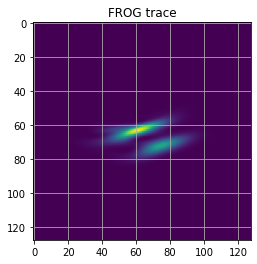

In [276]:
frog,delta = FROGs(frog_pred[0], frog_pred[1], frog_pred[2], frog_pred[3], frog_pred[4], frog_pred[5], frog_pred[6])
print(delta)
FROG_trace_plot(frog)